# [LAB 01] 비지도 학습 > 군집분석 >K MEANS > 성능 튜닝 평가

## 01. 준비작업
### [1] 패키지 가져오기

## #01. 준비작업
### [1] 패키지 참조

In [32]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame

from matplotlib import pyplot as plt
from matplotlib import font_manager as fm

import seaborn as sb
import numpy as np

# 클러스터링 관련 참조
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial import ConvexHull


#Elbow Point 계산 라이브러리
from kneed import KneeLocator

my_dpi = 200

### [2] 데이터 가져오기

In [3]:
origin = load_data('iris')
origin.head()

1936년 영국의 통계학자 로널드 피셔(Ronald A. Fisher)가 소개한 3가지 품종(setosa, versicolor, virginica)의 붓꽃(Iris)에 대한 꽃받침과 꽃잎의 길이와 너비 측정값으로 구성된 유명한 머신러닝 및 데이터 분석용 데이터셋.(출처: Kaggle)

field         description
------------  -------------
Sepal.Length  꽃밭침 길이
Sepal.Width   꽃밭침 너비
Petal.Length  꽃잎 길이
Petal.Width   꽃잎 너비
Species       품종



,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### [3] 데이터 전처리
- 군집 분석은 종속 변수가 존재하지 않으므로, 종속변수를 제외하여 데이터 추출
- 만약 군집분석 후 나눠진 군집을 기존의 종속변수와 비교하려는 시도는 로지스틱 회귀 분석으로 통계량이 제공되는 과정이 더 나을수 있음

In [29]:
df= origin.drop('Species' , axis=1)
df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## #02. K-Means 의 주요 하이퍼파라미터
- 하이퍼파라미터는 머신러닝 알고리즘에 전달하는 매개변수를 의미
- 프로그래밍 적으로는 함수 파라미터라 생각해도 무방

|하이퍼파리미터|기본값|설명|추천설명|
|-|-|-|-|
|n_clusters|8|군집 개수 k , 기본값은 의미 없음 |Elbow , Silhouette 등 근거로 결정|
|n_init|10|서로 다른 초기값으로 반복 실행 후 최적 결과 실행 | 10 dltkd (안정성 목적, 이본값 유지 권장)|
|max_iter|300|한번 실행 시 최대 반복 횟수|기본값 유지|
|random_state|None|초기화 난수 고정용, 결과 재현성 확보|고정 값 사용|


## #03. 최적의 클러스터 수 구하기
### [1] 이너셔 : K-Means 의 성능 평가 지표
- 각 데이터가 자신의 군집 중심까지 떨어진 거리의 제곱합
- 즉, 이 이너셔 값이 작을수록 각 데이터 포인트의 군집의 중심점을 기준으로 잘 뭉쳐있음을 의미
- 군집 내부 응집도 (군집 내부 압축 정도를 수치로 표현)
- 하지만 이너셔는 K 를 늘리면 무조건 줄어들기 떄문에 이녀셔가 작지만 K 가 너무 많지 않은 타협점을 찾아야하고, 그것이 엘보우 기법 (초반에는 급격하게 떨어지다가 어느순간 완만하게 줄어드는 지점을 찾아야함)

|구분|설명|
|-|-|
|수식|f$$\text{Inertia} = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - \mu_i \|$$, - $ $C$ : i번째 군집,  $ $\mu$ : i번째 군집 중심|
|무엇을 말해주나| - 데이터가 군집 중심으로 얼마나 가까운가 , - K 증가에 따른 오차 감소 효율|
|특징|1) K가 증가하면 응집도는 무조건 감소함 2) 절대값 해석 불가 3) 비교 기준은 같은 데이터로 K에 변환를 주면서 비교|

#### (1) 2-10 까지 군집의 수를 늘려가면서 Inertia 값을 확인해보자
- estimator.inertia_ 사용

In [6]:
klist = list(range(2,11))
inertia = [] # inertia 값을 저장할 리스트

for k in klist:
  estimator = KMeans(n_clusters = k , random_state=0)
  estimator.fit(X=df)
  inertia.append(estimator.inertia_)


inertia

[152.34795176035792,
 78.85566582597731,
 57.228473214285714,
 49.82774055829229,
 42.42154575309748,
 34.420191786283894,
 30.064593073593073,
 28.715856536394462,
 27.462118791296422]

#### (3) Inertia 값의 변화 시각화

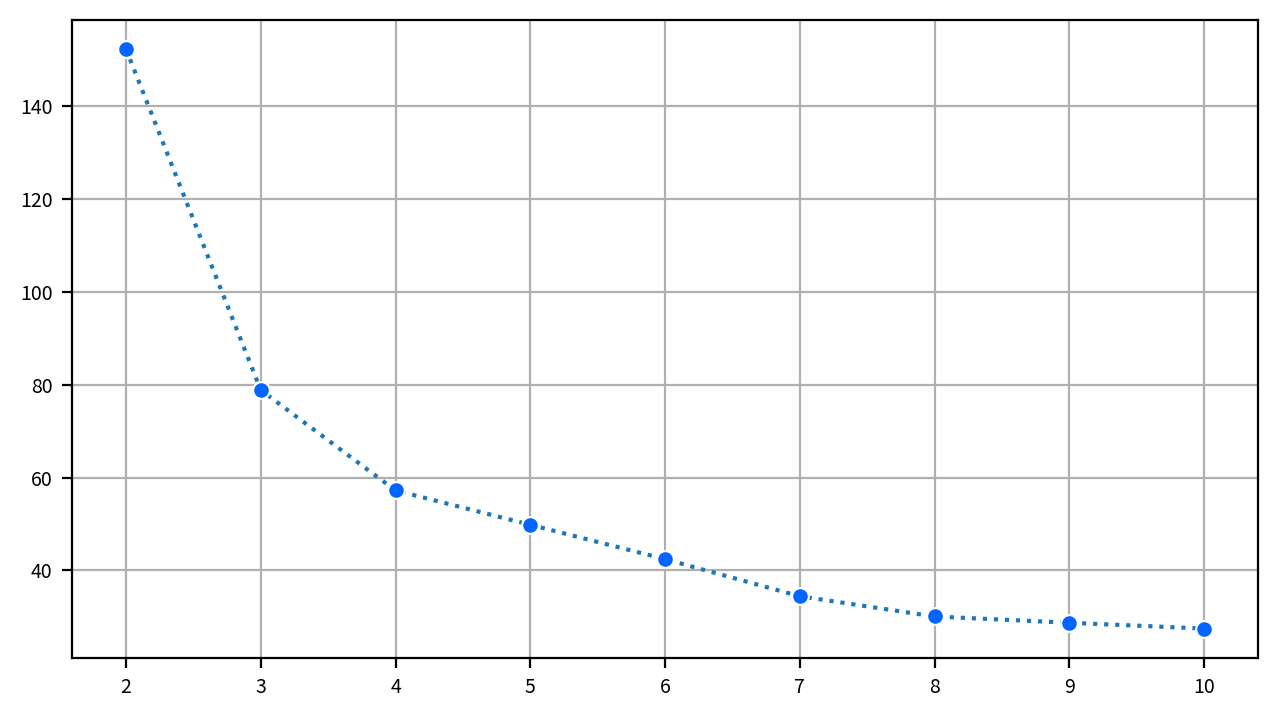

In [8]:
# 1) 그래프 초기화
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
my_dpi=200

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) Scatter Plot 그리기
sb.lineplot(x=klist, y=inertia, linestyle =':',marker ='o',markerfacecolor ='#0066ff' , markeredgecolor='#ffffff')

# 3) 그래프 꾸미기
ax.grid(True)                 # 배경 격자 표시/숨김

# 4) 출력
plt.tight_layout()            # 여백 제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료


> 인사이트 : 4 축이 4인 지점부터 감소가 완만하게 진행되는 형태로 바뀌었다, 따라서 최적의 클라스터 수는 3으로 판단할 수 있음

### [2] 엘보우포인트
k 증가에 따른 이너셔 추세를 시각화하여 감소 폭이 급격 -> 완만으로 바뀌는 지점
이 지점이 최적의 k 값이 된다

#### (1) 엘보우 포인트를 직접 구해보자
##### NumPy 를 사용한 기울기(변화율) 계산


- klist 와 inertia 에 들어있는 값들을 x,y 좌표로 보고
- 인접한 두 점 사이의 직선 기울기를 계산하여 slope_list 에 순서대로 저장


In [10]:

slope_list =[0]
for i in range(1,len(inertia)):
  #i-1, 과 i 를 사용해서 연속된 두 점을 비교

  x1 =klist[i-1]
  y1=inertia[i-1]
  x2=klist[i]
  y2=inertia[i]
  
  #polyfit 은 1차 함수 ax+b 형태를 피팅하는 것으로, slope 에는 기울기 a, _ 에는 절편 b 가 리턴될 예정 (절편은 사용하지 않을 에정이니 _ 로 무시 처리)

  #slope 는 y2-y1 / x2-x1
  slope , _ = np.polyfit([x1,x2],[y1,y2],1)
  slope_list.append(slope)



# 이전 점 > 현재 점으로의 변환율 값이 담기게 된다
slope_list

[0,
 np.float64(-73.4922859343805),
 np.float64(-21.62719261169159),
 np.float64(-7.4007326559934485),
 np.float64(-7.406194805194824),
 np.float64(-8.001353966813582),
 np.float64(-4.355598712690802),
 np.float64(-1.3487365371986073),
 np.float64(-1.2537377450980371)]

#### 기울기의 평균 (변환율의 평균을 구해준다)


In [11]:
avg_slope = np.mean(slope_list)
avg_slope

np.float64(-13.876203663229042)

#### 기울기가 평균보다 작은 지점 찾기 (평균 변화율보다 크게 감소하는 첫 번째 지점 찾기)

- 기울기 slope_list 중에서 평균 기울기 avg_slope 보다 작은 값들만 골라서
- 그 중 가장 큰 기울기 (덜 급격하게 감소하기 시작하는 지점)의 인덱스를 elbow point 로 선택

In [13]:
ev = []   #elbow values : 조건을 만족하는 기울기 값들
ei = []   #elbow indices : 그 기울기 값이 있던 인덱스 i

for i,v in enumerate(slope_list):   # i 는 인덱스 k 값의 위치 | v 는 해당 인덱스 의 기울기 값

  if v < avg_slope:  #해당 조건을 만족할 떄의 기울기값과 위치값들을 저장함
    ev.append(v)    
    ei.append(i)


elbow_point = ei[np.argmax(ev)]  # np.argmax(ev) 는 ev 에서 가장 큰 값의 인덱스
elbow_point

2

#### 최적의 군집수

In [14]:
best_k = klist[elbow_point]
best_k

4

#### Elbow Point 를 포함한 Inertia 시각화

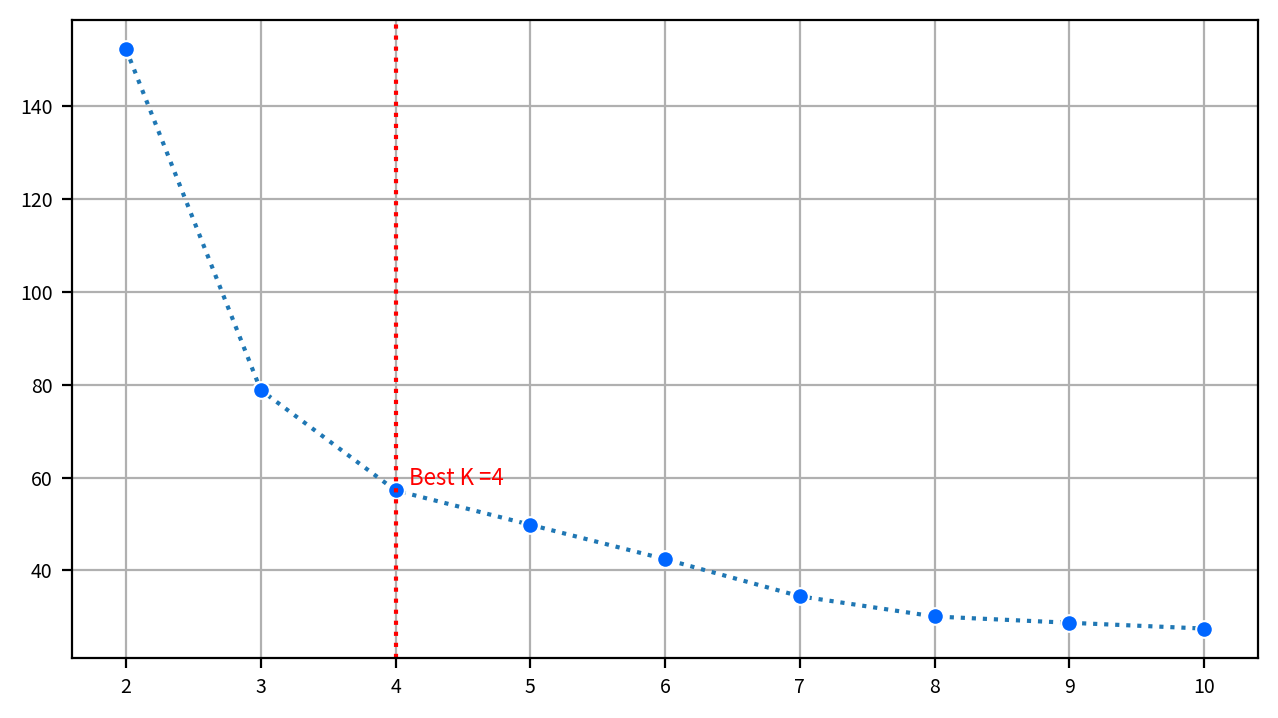

In [15]:
# 1) 그래프 초기화
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
my_dpi=200

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) Line Plot 그리기
sb.lineplot(x=klist, 
            y=inertia, 
            linestyle =':',
            marker ='o',
            markerfacecolor ='#0066ff' , 
            markeredgecolor='#ffffff')

#엘보우 포인트 표시
ax.axvline(x=best_k,color='red',linestyle=':')
ax.text(
  best_k + 0.1,
  inertia[elbow_point] +0.1,
  'Best K =%d' % best_k,
  fontsize=8,
  ha='left',
  va='bottom',
  color='r'

)


# 3) 그래프 꾸미기
ax.grid(True)                 # 배경 격자 표시/숨김

# 4) 출력
plt.tight_layout()            # 여백 제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료


### (2) 엘보우 포인트 자동 구하기
#### KneeLocator 라이브러리 활용

|파라미터|값|의미|
|-|-|-|
|curve|convex|볼록함|
|curve|concave|오목함|
|direction|increasing|x가 커짐에 따라 y 가 점점 커짐|
|direction|decreasing|x가 커짐에 따라 y가 점점 작아짐|


🔹 Convex (볼록)
두 점을 직선으로 이었을 때 그래프가 그 직선 아래에 있음

🔹 Concave (오목)
두 점을 직선으로 이었을 때 그래프가 그 직선 위에 있음

- Kneed 라이브러리의 KneeLocator 를 써서 ELBOW 지점을 자동으로 찾아주는 방법
- klist 와 inertia 를 입력하면 최적의 k 와 그때의 inertia 값을 출력함

In [17]:
#y 값이 감소하는 방향에서, 감소하는 볼록
kl = KneeLocator(klist,inertia,curve='convex',direction='decreasing')

best_k = kl.elbow   #최적의 k 값 출력
best_y=kl.elbow_y   #최적의 inertia 값 출력

print('found elbow' , best_k)
print('found y:' , best_y)

found elbow 4
found y: 57.228473214285714


#### 클러스터링 시각화


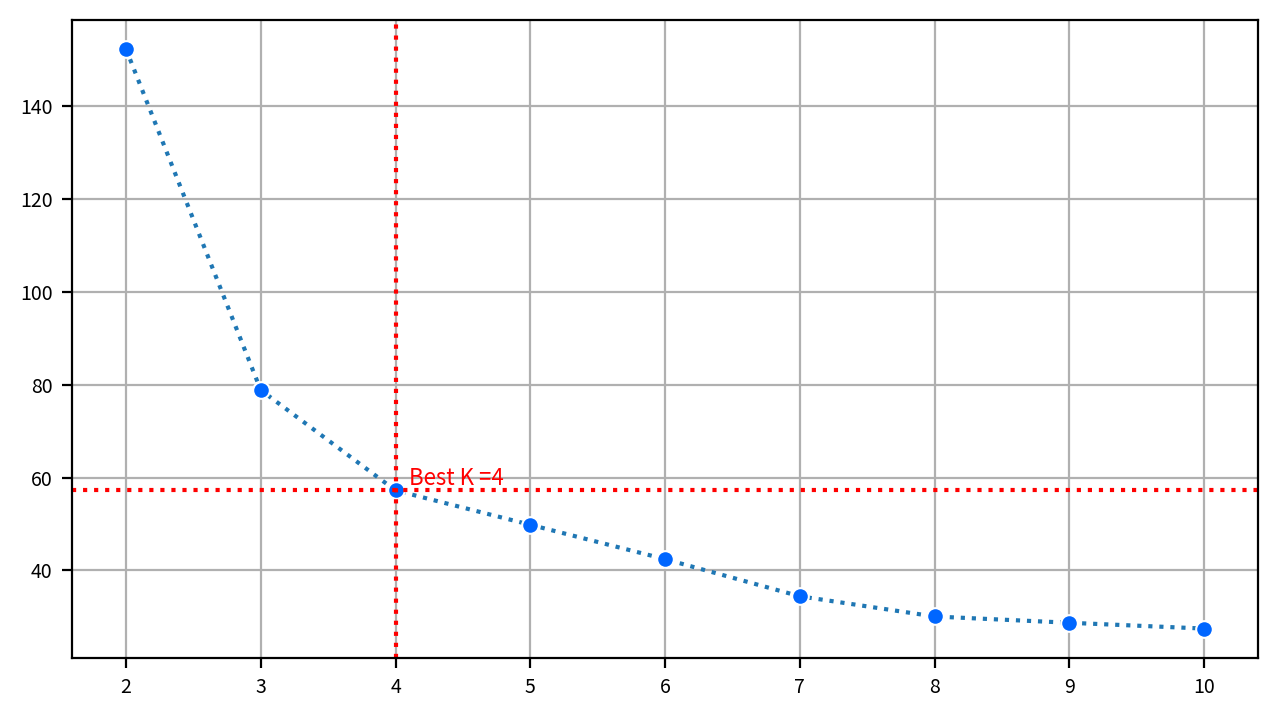

In [22]:
# 1) 그래프 초기화
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
my_dpi=200

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) Line Plot 그리기
sb.lineplot(x=klist, 
            y=inertia, 
            linestyle =':',
            marker ='o',
            markerfacecolor ='#0066ff' , 
            markeredgecolor='#ffffff')

#엘보우 포인트 표시
ax.axvline(x=best_k,color='red',linestyle=':')
ax.axhline(y=best_y,color='red',linestyle=':')

ax.text(
  best_k + 0.1,
  inertia[elbow_point] +0.1,
  'Best K =%d' % best_k,
  fontsize=8,
  ha='left',
  va='bottom',
  color='r'

)


# 3) 그래프 꾸미기
ax.grid(True)                 # 배경 격자 표시/숨김

# 4) 출력
plt.tight_layout()            # 여백 제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료


#### (3) 도출된 결과를 적용한 클러스터링

In [23]:
estimator = KMeans(n_clusters=best_k)  #모델 객체 생성
estimator.fit(df) #모델 학습

cluster =estimator.predict(df)  #예측
df['ClusterID'] = cluster
df

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,ClusterID
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,3
146,6.3,2.5,5.0,1.9,0
147,6.5,3.0,5.2,2.0,0
148,6.2,3.4,5.4,2.3,3


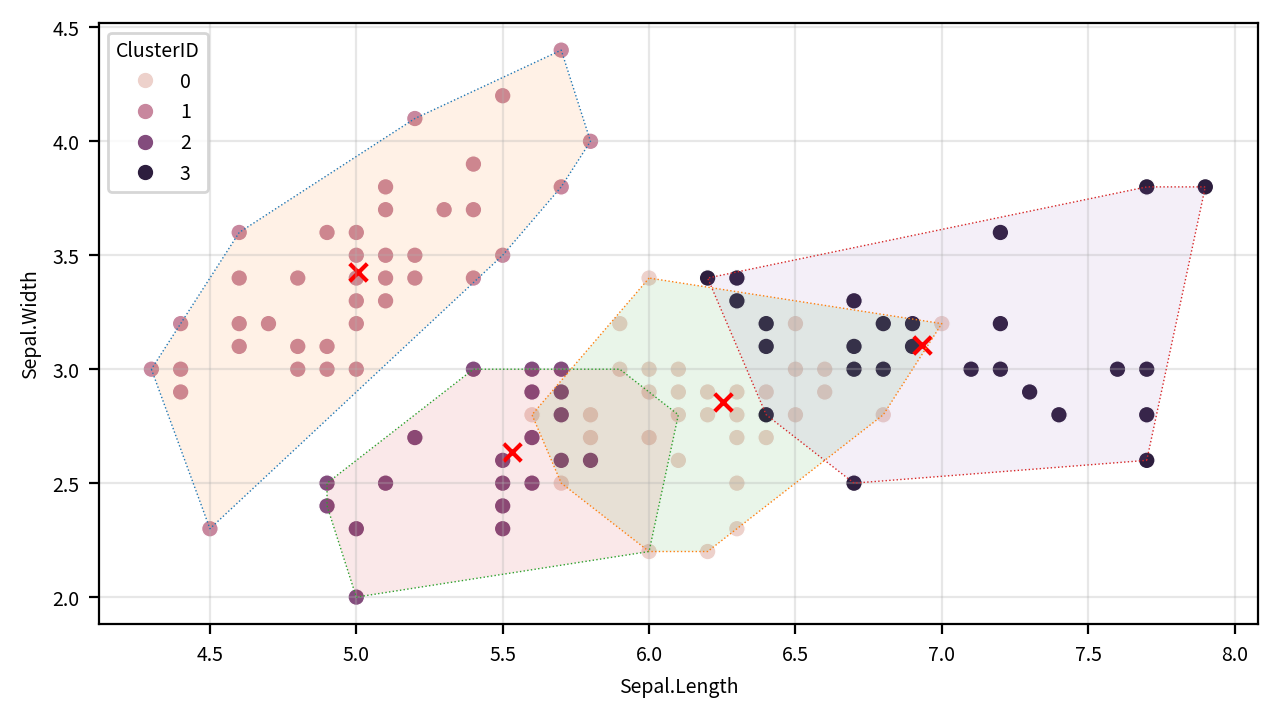

In [28]:
vdf = df.copy()
hue_field ='ClusterID'
x_field ='Sepal.Length'
y_field = 'Sepal.Width'

# 1) 그래프 초기화
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
my_dpi=200

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


#데이터 산점도
sb.scatterplot (data=vdf , x=x_field , y=y_field , hue=hue_field)



# 군집별 값의 종류별로 반복문 실행
for c in vdf[hue_field].unique():
  #값의 종류별로 데이터 프레임 구분
  df_c = vdf.loc[vdf[hue_field] == c , [x_field,y_field]]

  try:
    #외각선 좌표 계산
    hull = ConvexHull(df_c)

    #마지막 좌표 이후에 첫번쨰 좌표를 연결
    points = np.append(hull.vertices,hull.vertices[0])

    ax.plot( #type:ignore
      df_c.iloc[points,0] , df_c.iloc[points,1] , linewidth = 0.5 , linestyle =':'
      )
    
    ax.fill(df_c.iloc[points,0] , df_c.iloc[points ,1], alpha =0.1)


  except:
    pass

#군집별 중심점 표시
ax.scatter(
  estimator.cluster_centers_[:,0],
  estimator.cluster_centers_[:,1],
  marker='x',
  c='red',
  alpha=1,
  s=40
)


ax.grid(True ,alpha =0.3) #배경 격자 표시
plt.tight_layout()
plt.show()
plt.close()

> 군집들이 겹쳐져 있는 이유 : 군집 분석 시 고려했던 컬럼 수는 4개인데, 현재 그래프는 2차원이다 보니 다른 변수들간의 관계가 보이지 않는것